<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [77]:
%pip install statsmodels
%pip install mpmath

Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 532 kB 1.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [57]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem
from scipy.stats import bernoulli, beta               


import pylab as plt

In [10]:
# datos
df = pd.read_csv('data/cookie_cats.csv')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [20]:
# transformacion

control = df[df["version"] =="gate_30"]

tratamiento = df[df["version"] =="gate_40"]

In [51]:
imps_ctrl, reten_ctrl = len(control), len(control[control["retention_1"] == True])          # jugar, quedarse
imps_tra, reten_tra = len(tratamiento), len(tratamiento[tratamiento["retention_1"] == True])  # jugar, quedarse
CR_ctrl=reten_ctrl/imps_ctrl
CR_tra=reten_tra/imps_tra

In [54]:
f'TASAS: Control={CR_ctrl}, Test={CR_tra}'

'TASAS: Control=0.4481879194630872, Test=0.44228274967574577'

In [63]:
a_C, b_C = reten_ctrl+1, imps_ctrl-reten_ctrl+1
a_T, b_T = reten_tra+1, imps_tra-reten_tra+1

beta_control=beta(a_C, b_C)
beta_test=beta(a_T, b_T)

In [65]:
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [211]:
# muestreo
x=np.linspace(0.4, 0.5, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

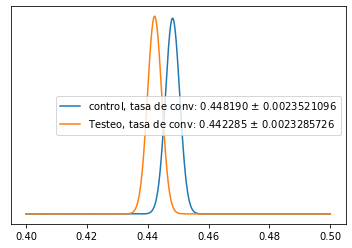

In [212]:
plot([beta_control, beta_test], ['control', 'Testeo'])


In [195]:
# testeo para retention_1

salto=(beta_test.mean()-beta_control.mean())/beta_control.mean()
salto

-0.013175098158249857

In [177]:
from mpmath import betainc   # integral de beta

prob=betainc(a_T, b_T, , 1, regularized=True)

prob=float(prob)

prob

1.0

In [206]:
1-beta_control.cdf(0.44524)

0.8951649179127248

0.9978

con toda probabilidad la actualizacion tendra una tasa de retencion un 1,3175% mas baja en el primer dia

In [215]:
# testeo para retention_7
imps_ctrl, reten_ctrl = len(control), len(control[control["retention_7"] == True])          # jugar, quedarse
imps_tra, reten_tra = len(tratamiento), len(tratamiento[tratamiento["retention_7"] == True])  # jugar, quedarse
CR_ctrl=reten_ctrl/imps_ctrl
CR_tra=reten_tra/imps_tra


In [216]:
a_C, b_C = reten_ctrl+1, imps_ctrl-reten_ctrl+1
a_T, b_T = reten_tra+1, imps_tra-reten_tra+1

beta_control=beta(a_C, b_C)
beta_test=beta(a_T, b_T)

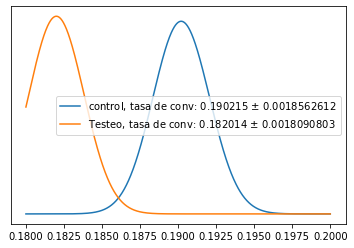

In [227]:
x=np.linspace(0.18, 0.2, 1000)

plot([beta_control, beta_test], ['control', 'Testeo'])


In [228]:
1-beta_control.cdf(0.18608)

0.9873800455380075

In [229]:
salto=(beta_test.mean()-beta_control.mean())/beta_control.mean()
salto

-0.04311526114658881

In [ ]:
# conclusiones

# Explica detalladamente las conclusiones obtenidas de. tu testeo.
#la nueva version tiene menos eindice de compra y es mas acusado en el dia 7 que enel 1


